# Wind Power Generation Analysis 
This notebook consolidates data processing, model training, and evaluation in a clear, streamlined workflow.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from pysr import PySRRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy import stats
from pandas.tseries.offsets import DateOffset

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font_scale=0.9)


In [78]:
# Load data
DATA_PATH = 'Wind_data/Location1.csv'
data = pd.read_csv(DATA_PATH, parse_dates=['Time'], index_col='Time')

# Define features and target
feature_cols = [
    'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
    'windspeed_100m', 'windgusts_10m', 'winddirection_100m'
]

target = 'Power'

data = data.dropna(subset=feature_cols + [target])
# Scale features
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])


In [ ]:
# Preprocessing and train/test split with user-defined training duration

# Drop missing values
data = data.dropna(subset=feature_cols + [target])

# Remove outliers using z-score (threshold = 3)

z_scores = np.abs(stats.zscore(data[feature_cols + [target]]))
data = data[(z_scores < 3).all(axis=1)]

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

# Ensure the DataFrame is sorted by time
data = data.sort_index()

# User-defined number of months for training
months_data = 3  # set this to the number of months to use for training

train_end = data.index.max()
# Determine the cutoff date for the training set
train_start = train_end - pd.DateOffset(months=months_data)

# Split into training and test sets based on date
data = data[data.index >=train_start].copy()

# Create circular features for wind direction
data['sin_winddir_100m'] = np.sin(np.radians(data['winddirection_100m']))
data['cos_winddir_100m'] = np.cos(np.radians(data['winddirection_100m']))

feature_cols= [
    'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
    'windspeed_100m', 'windgusts_10m', 'sin_winddir_100m',
    'cos_winddir_100m'
]
# Calculate the split index for 80% of the data
split_index = int(len(data) * 0.8)

# Split the data into training and testing sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Extract feature matrices and target vectors
X_train = train_data[feature_cols].values
y_train = train_data[target].values
X_test = test_data[feature_cols].values
y_test = test_data[target].values

# Add actual target values to the test DataFrame
test_data['Actual Power'] = y_test

data.head()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,sin_winddir_100m,cos_winddir_100m
Time,,,,,,,,,,,
2021-09-30 23:00:00,0.247252,0.988929,0.573926,1.87,-0.787488,106,-0.978669,-1.317277,0.0334,-0.017080,0.999854
2021-10-01 00:00:00,0.231846,0.929454,0.552620,1.70,-0.934599,118,-0.876799,-1.228740,0.0275,-0.015302,0.999883
2021-10-01 01:00:00,0.185630,1.048405,0.541966,1.53,-0.988798,122,-0.795303,-1.494353,0.0216,-0.013880,0.999904
2021-10-01 02:00:00,0.206170,1.107880,0.568599,1.66,-0.973312,123,-0.764742,-1.435328,0.0157,-0.013347,0.999911
2021-10-01 03:00:00,0.206170,1.167355,0.584579,1.63,-0.981055,137,-0.673059,-1.258252,0.0098,-0.011747,0.999931


### Pearson Correlation Matrix

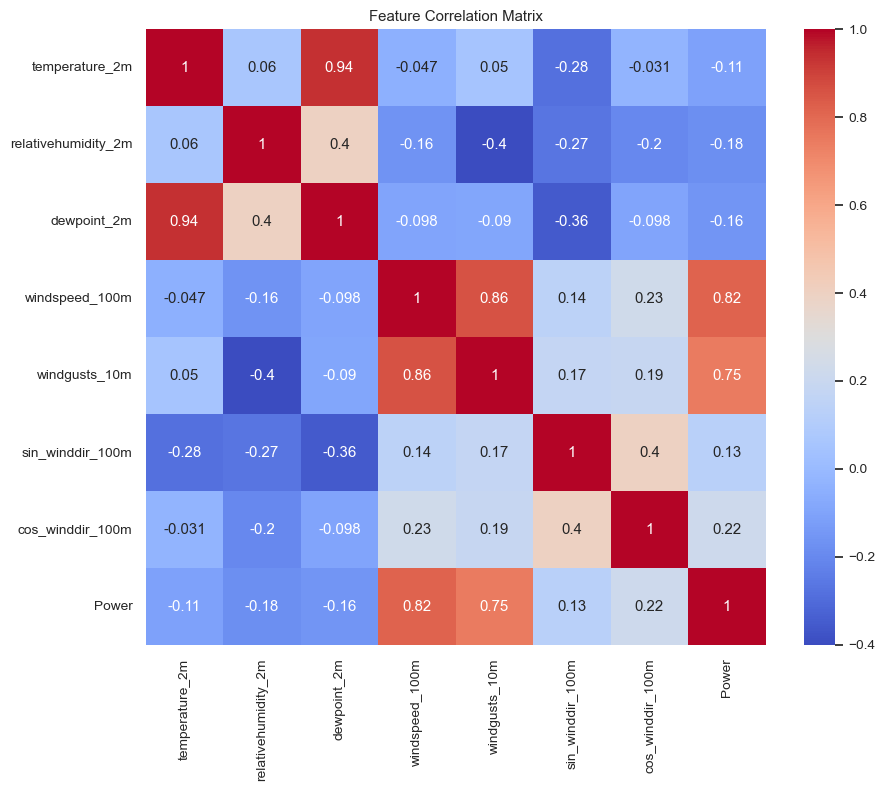

In [80]:
all_cols = feature_cols + [target] 

corr = data[all_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

## Symbolic Regression (Initial)

In [81]:
# Initial PySR model
sr = PySRRegressor(
    niterations=100,
    binary_operators=['+', '-', '*', '/'],
    unary_operators=['sin', 'cos', 'cube'],
    extra_sympy_mappings={'cube': lambda x: x**3},
    loss='loss(x, y) = (x - y)^2',
    populations=50,
    verbosity=0
)

sr.fit(X_train, y_train)
y_pred_sr = sr.predict(X_test)
test_data['Predicted_SR'] = y_pred_sr
rmse_sr = mean_squared_error(y_test, y_pred_sr, squared=False)
mae_sr = mean_absolute_error(y_test, y_pred_sr)
print(f"Initial SR → RMSE: {rmse_sr:.4f}, MAE: {mae_sr:.4f}")

# Print the best equation found by the symbolic regression model
best_equation = sr.get_best()
print("Best equation found by symbolic regression:")
print(best_equation)


Initial SR → RMSE: 0.2233, MAE: 0.1723
Best equation found by symbolic regression:
complexity                                                5
loss                                               0.029916
equation                      (x3 * 0.2726004) + 0.40441748
score                                              1.213038
sympy_format                      x3*0.2726004 + 0.40441748
lambda_format    PySRFunction(X=>x3*0.2726004 + 0.40441748)
Name: 3, dtype: object


## Symbolic Regression (Updated)

In [83]:
# Updated PySR model with feature names
sr_updated = PySRRegressor(
    niterations=100,
    binary_operators=['+', '-', '*', '/'],
    unary_operators=['sin', 'cos', 'cube'],
    extra_sympy_mappings={'cube': lambda x: x**3},
    loss='loss(x, y) = (x - y)^2',
    populations=50,
    verbosity=0
)
# add the result from previous model as a feature
X_train_from_prev_SR= sr.predict(X_train)
X_test_from_prev_SR = sr.predict(X_test)

X_train_with_pred = np.column_stack((X_train, X_train_from_prev_SR))
X_test_with_pred = np.column_stack((X_test, X_test_from_prev_SR))

sr_updated.fit(X_train_with_pred, y_train)
y_pred_sr_upd = sr_updated.predict(X_test_with_pred)
test_data['Predicted_SR_Updated'] = y_pred_sr_upd
rmse_sr_upd = mean_squared_error(y_test, y_pred_sr_upd, squared=False)
mae_sr_upd = mean_absolute_error(y_test, y_pred_sr_upd)
print(f"Updated SR → RMSE: {rmse_sr_upd:.4f}, MAE: {mae_sr_upd:.4f}")

# Print the best equation found by the symbolic regression model
best_equation = sr_updated.get_best()
print("Best equation found by symbolic regression:")
print(best_equation)


Updated SR → RMSE: 0.2114, MAE: 0.1585
Best equation found by symbolic regression:
complexity                                             5
loss                                            0.026673
equation                       cube(sin(x7 + 0.4090705))
score                                           0.055951
sympy_format                      sin(x7 + 0.4090705)**3
lambda_format    PySRFunction(X=>sin(x7 + 0.4090705)**3)
Name: 2, dtype: object


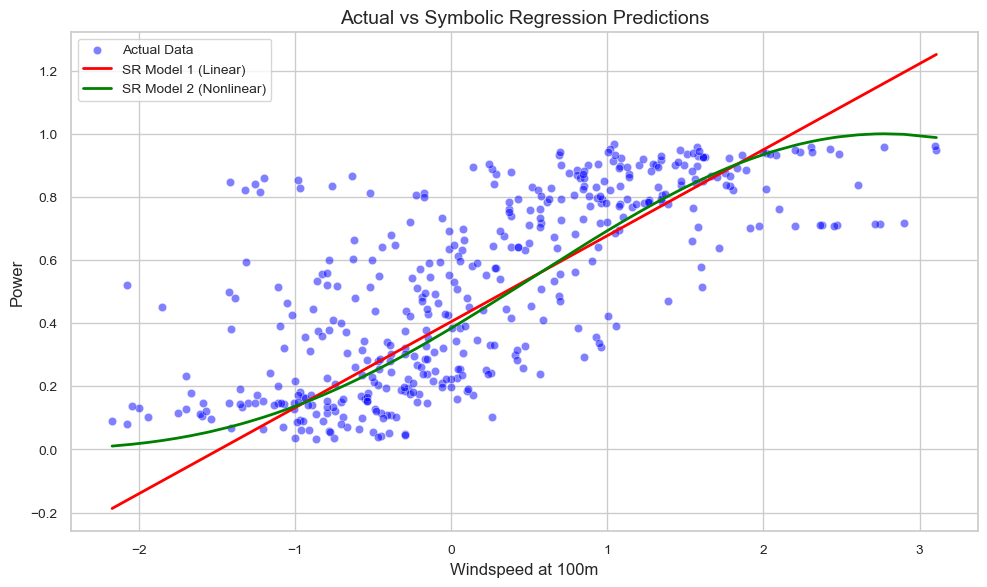

In [90]:
# Predict using both symbolic regression models
y_pred_sr1 = sr.predict(X_test)
y_pred_sr2 = sr_updated.predict(X_test_with_pred)

# Add predictions to the test data for plotting (optional)
test_data['Predicted_SR1'] = y_pred_sr1
test_data['Predicted_SR2'] = y_pred_sr2

# Sort by windspeed for smooth lines
sorted_indices = np.argsort(test_data['windspeed_100m'])
sorted_windspeed = test_data['windspeed_100m'].iloc[sorted_indices]
sorted_actual = test_data['Actual Power'].iloc[sorted_indices]
sorted_pred_sr1 = y_pred_sr1[sorted_indices]
sorted_pred_sr2 = y_pred_sr2[sorted_indices]

# Create the plot
plt.figure(figsize=(10, 6))

# Actual data
sns.scatterplot(x=test_data['windspeed_100m'], y=test_data['Actual Power'],
                label='Actual Data', color='blue', alpha=0.5)

# SR model 1
plt.plot(sorted_windspeed, sorted_pred_sr1, label='SR Model 1 (Linear)', color='red', linewidth=2)

# SR model 2
plt.plot(sorted_windspeed, sorted_pred_sr2, label='SR Model 2 (Nonlinear)', color='green', linewidth=2)

# Labels and layout
plt.title('Actual vs Symbolic Regression Predictions', fontsize=14)
plt.xlabel('Windspeed at 100m', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM Time Series Forecasting

In [85]:
# Prepare sequences for LSTM
def create_seq(dataset, look_back):
    Xs, ys = [], []
    for i in range(look_back, len(dataset)):
        Xs.append(dataset[i-look_back:i, 0])  # Use the previous 'look_back' values
        ys.append(dataset[i, 0])  # Use the current value as the target
    return np.array(Xs), np.array(ys)

# Define look_back (number of timesteps in each sequence)
look_back = 52

# Extract the target column as a NumPy array
ts = data[[target]].values

# Create sequences
seq_x, seq_y = create_seq(ts, look_back)

# Adjust the split index to account for the reduced size
split_seq = split_index - look_back

# Split the sequences into training and testing sets
X_train_ts, X_test_ts = seq_x[:split_seq], seq_x[split_seq:]
y_train_ts, y_test_ts = seq_y[:split_seq], seq_y[split_seq:]

# Reshape for LSTM [samples, timesteps, features]
X_train_ts = X_train_ts.reshape(-1, look_back, 1)
X_test_ts = X_test_ts.reshape(-1, look_back, 1)

# Build and train LSTM
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.fit(X_train_ts, y_train_ts, epochs=5, batch_size=32, verbose=1)

# Predict on the test set
pred_lstm = lstm.predict(X_test_ts).flatten()


# Align predictions with the test data
test_data['Predicted_LSTM'] = pred_lstm

# Calculate RMSE and MAE
rmse_lstm = mean_squared_error(test_data['Actual Power'], pred_lstm, squared=False)
mae_lstm = mean_absolute_error(test_data['Actual Power'], pred_lstm)

# Print RMSE and MAE
print(f"LSTM → RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}")

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0748
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0129
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0065
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0040
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0027
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM → RMSE: 0.0468, MAE: 0.0344


## Combined Predictions and Metrics

In [86]:
# Display a sample of predictions
test_data.head()


,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,sin_winddir_100m,cos_winddir_100m,Actual Power,Predicted_SR,Predicted_SR_Updated,Predicted_LSTM
Time,,,,,,,,,,,,,,,
2021-12-13 05:00:00,-0.543571,-1.092706,-0.880228,5.06,1.202387,232,0.325265,0.778117,0.8999,0.005677,0.999984,0.8999,0.732189,0.751483,0.889427
2021-12-13 06:00:00,-0.497354,-0.914280,-0.763044,5.39,1.434668,230,0.304891,0.601042,0.9004,0.005321,0.999986,0.9004,0.795509,0.813966,0.881632
2021-12-13 07:00:00,-0.543571,-0.795330,-0.768370,5.33,1.488867,230,0.304891,0.748605,0.9009,0.005321,0.999986,0.9009,0.810283,0.827611,0.879948
2021-12-13 08:00:00,-0.471678,-0.914280,-0.741737,5.24,1.310785,235,0.335452,0.748605,0.9014,0.005855,0.999983,0.9014,0.761738,0.781397,0.882948
2021-12-13 09:00:00,-0.343298,-1.092706,-0.677818,4.61,0.877194,229,0.294704,0.896168,0.9019,0.005144,0.999987,0.9019,0.643541,0.655600,0.887181


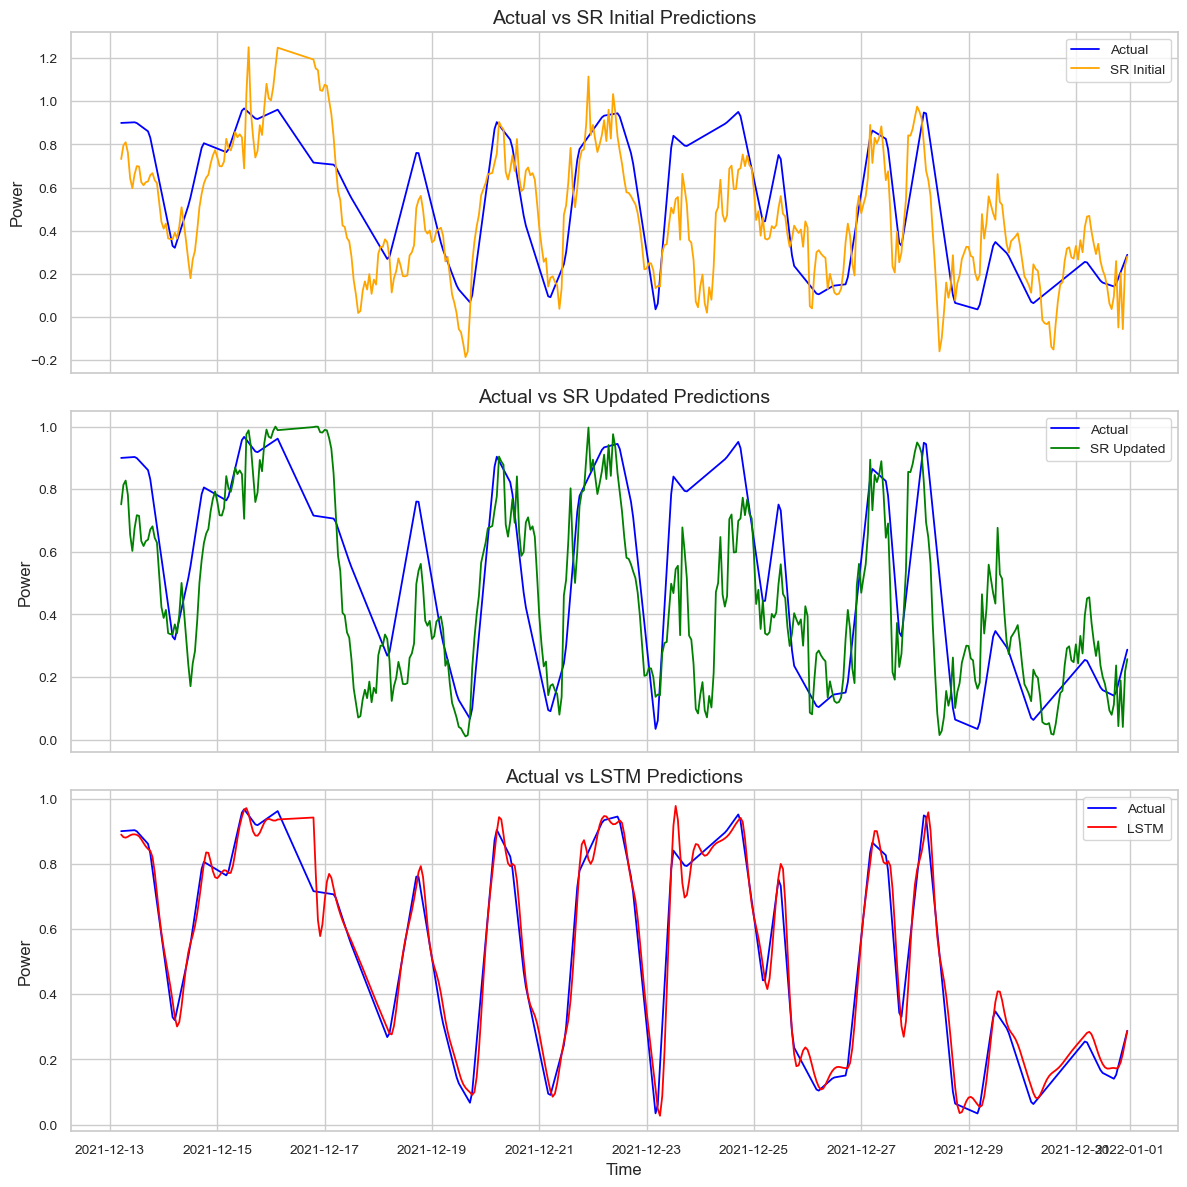

In [87]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Subplot 1: Actual vs SR Initial
axes[0].plot(test_data.index, test_data['Actual Power'], label='Actual', linewidth=1.3, color='blue')
axes[0].plot(test_data.index, test_data['Predicted_SR'], label='SR Initial', linewidth=1.3, color='orange')
axes[0].set_title('Actual vs SR Initial Predictions', fontsize=14)
axes[0].set_ylabel('Power', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Actual vs SR Updated
axes[1].plot(test_data.index, test_data['Actual Power'], label='Actual', linewidth=1.3, color='blue')
axes[1].plot(test_data.index, test_data['Predicted_SR_Updated'], label='SR Updated', linewidth=1.3, color='green')
axes[1].set_title('Actual vs SR Updated Predictions', fontsize=14)
axes[1].set_ylabel('Power', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Subplot 3: Actual vs LSTM
axes[2].plot(test_data.index, test_data['Actual Power'], label='Actual', linewidth=1.3, color='blue')
axes[2].plot(test_data.index, test_data['Predicted_LSTM'], label='LSTM', linewidth=1.3, color='red')
axes[2].set_title('Actual vs LSTM Predictions', fontsize=14)
axes[2].set_xlabel('Time', fontsize=12)
axes[2].set_ylabel('Power', fontsize=12)
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()